# <p style="background-color: #d4edda; font-family: Algerian; font-size: 200%; text-align: center; color: black; border-radius: 1000px 50px;">Kathmandu Air Quality: Hazard Prediction Pipeline</p>

### Ensemble Learning | Optuna Optimization | LIME Interpretability

**Project Overview:**  
This notebook develops a production-grade machine learning pipeline to predict whether air quality in Kathmandu will reach **hazardous levels** within the next 24 hours. We utilize a combination of Linear Models, Tree-based Ensembles, and GPU-accelerated Boosting.

**Key Features:**
*   **Optimization:** Hyperparameter tuning via Optuna.
*   **Ensembling:** Comparing Soft Voting vs. Meta-Stacking.
*   **Interpretability:** Global impact (Logistic Regression) vs. Local impact (LIME).
*   **Hardware:** Leveraging NVIDIA GPU for XGBoost.

## <p style="background-color: #d4edda; font-family: Algerian; font-size: 200%; text-align: center; color: black; border-radius: 10px 10px;">Module Imports and Plot Style</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import optuna
import xgboost as xgb
import lime
import lime.lime_tabular
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, 
                             precision_recall_curve, average_precision_score, auc, roc_curve)
from sklearn.model_selection import TimeSeriesSplit

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [2]:
# --- 1. SETUP & STYLE ---
MICKEY_RED, MICKEY_YELLOW, MICKEY_BLACK, MICKEY_BLUE = "#FF0000", "#FFD700", "#222222", "#00A8E8"

def set_mickey_style():
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({
        'font.weight': 'bold', 'axes.labelweight': 'bold', 'axes.titleweight': 'bold',
        'axes.titlesize': 18, 'axes.labelsize': 14, 'axes.edgecolor': MICKEY_BLACK,
        'axes.linewidth': 2.5, 'lines.linewidth': 3
    })

set_mickey_style()

## <p style="background-color: #d4edda; font-family: Algerian; font-size: 200%; text-align: center; color: black; border-radius: 10px 10px;">Data Preparation and Encoding</p>


In [ ]:
df = pd.read_csv('kathmandu_aq_ml_ready.csv', parse_dates=['timestamp'])

In [4]:
df.columns

Index(['timestamp', 'pm25', 'temp', 'feelslike', 'dew', 'humidity', 'precip',
       'precipprob', 'preciptype', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'conditions', 'weather_summary', 'hour',
       'month', 'day_of_week', 'season', 'brick_kiln_active', 'month_sin',
       'month_cos', 'hour_sin', 'hour_cos', 'is_rush_hour', 'is_weekend',
       'pm25_lag_1h', 'pm25_lag_2h', 'pm25_rolling_6h', 'pm25_rolling_24h',
       'precip_lag_3h', 'visibility_lag_3h', 'temp_diff_6h',
       'is_hazardous_now', 'target_next_24h'],
      dtype='object')

In [5]:
df.head()

,timestamp,pm25,temp,feelslike,dew,humidity,precip,precipprob,preciptype,windgust,...,is_weekend,pm25_lag_1h,pm25_lag_2h,pm25_rolling_6h,pm25_rolling_24h,precip_lag_3h,visibility_lag_3h,temp_diff_6h,is_hazardous_now,target_next_24h
0,2022-01-02 05:00:00,57.0,41.0,41.0,41.0,100.00,0.0,0,none,6.9,...,0,71.0,76.0,81.000000,73.833333,0.0,3.1,-5.4,0,0.0
1,2022-01-02 06:00:00,69.0,39.9,39.9,39.6,98.75,0.0,0,none,7.8,...,0,57.0,71.0,70.166667,73.625000,0.0,3.1,-5.0,0,0.0
2,2022-01-02 07:00:00,69.0,41.0,41.0,41.0,100.00,0.0,0,none,8.5,...,0,69.0,57.0,66.833333,72.541667,0.0,1.9,-1.8,0,0.0
3,2022-01-02 08:00:00,86.0,44.6,44.6,42.8,93.35,0.0,0,none,8.5,...,0,69.0,69.0,71.333333,72.000000,0.0,1.9,1.8,0,0.0
4,2022-01-02 09:00:00,143.0,46.1,46.1,43.0,89.11,0.0,0,none,8.9,...,0,86.0,69.0,82.500000,72.416667,0.0,1.9,4.4,0,0.0


In [6]:
# df.dtypes.reset_index().rename(
#     columns={"index": "column", 0: "dtype"}
# )

In [7]:
cols_to_drop = ['timestamp', 'is_hazardous_now']
df_ml = df.drop(columns=cols_to_drop)

In [8]:
# One-hot encoding

categorical_cols = ['season', 'preciptype', 'conditions', 'weather_summary']
df_ml = pd.get_dummies(df_ml, columns=categorical_cols, drop_first=True)

In [9]:
df_ml.isnull().sum()

pm25                                   0
temp                                   0
feelslike                              0
dew                                    0
humidity                               0
precip                                 0
precipprob                             0
windgust                               0
windspeed                              0
winddir                                0
sealevelpressure                       0
cloudcover                             0
visibility                             0
solarradiation                         0
solarenergy                            0
uvindex                                0
hour                                   0
month                                  0
day_of_week                            0
brick_kiln_active                      0
month_sin                              0
month_cos                              0
hour_sin                               0
hour_cos                               0
is_rush_hour    

In [10]:
df_ml = df_ml.dropna()

In [11]:
print(f"Final Feature Set: {df_ml.columns.tolist()}")
print(f"Dataset Shape for ML: {df_ml.shape}")

Final Feature Set: ['pm25', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'hour', 'month', 'day_of_week', 'brick_kiln_active', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'is_rush_hour', 'is_weekend', 'pm25_lag_1h', 'pm25_lag_2h', 'pm25_rolling_6h', 'pm25_rolling_24h', 'precip_lag_3h', 'visibility_lag_3h', 'temp_diff_6h', 'target_next_24h', 'season_Post-Monsoon', 'season_Pre-Monsoon', 'season_Winter', 'preciptype_rain', 'conditions_Overcast', 'conditions_Partially cloudy', 'conditions_Rain', 'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy', 'weather_summary_clear-night', 'weather_summary_cloudy', 'weather_summary_fog', 'weather_summary_partly-cloudy-day', 'weather_summary_partly-cloudy-night', 'weather_summary_rain', 'weather_summary_wind']
Dataset Shape for ML: (24479, 50)


In [12]:
X = df_ml.drop(columns=['target_next_24h'])
y = df_ml['target_next_24h']
feature_names = X.columns.tolist()

In [13]:
# Time-Series Split (80/20)

split_point = int(len(df_ml) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## <p style="background-color: #d4edda; font-family: Algerian; font-size: 200%; text-align: center; color: black; border-radius: 10px 10px;">Model Interpretation (Part 1)</p>

Before building complex ensembles, we look at **Logistic Regression** coefficients. This tells us the general "odds" of a hazard based on each feature. 
*Positive values (Red) increase hazard risk; Negative values (Blue) decrease it.*

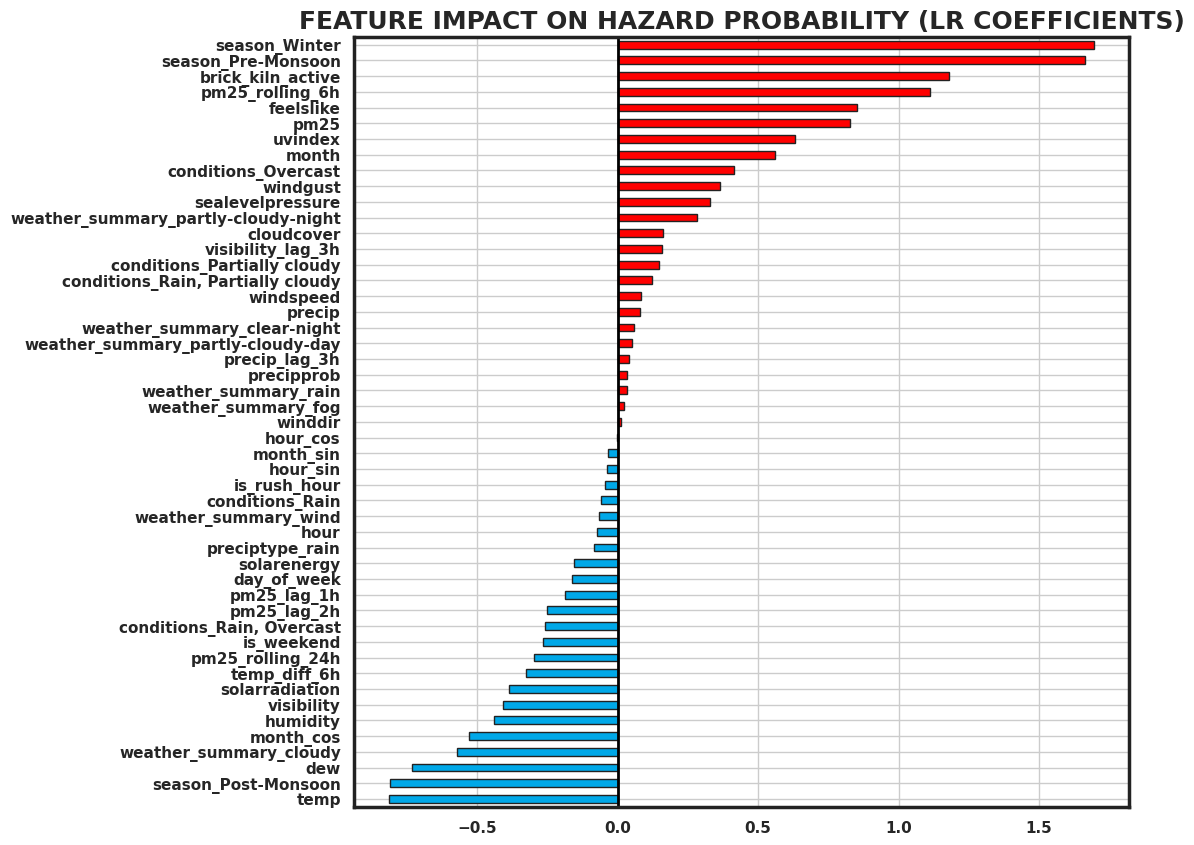

In [15]:
lr_baseline = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_baseline.fit(X_train_scaled, y_train)

weights = pd.Series(lr_baseline.coef_[0], index=feature_names).sort_values()
plt.figure(figsize=(10, 10))
colors = [MICKEY_RED if x > 0 else MICKEY_BLUE for x in weights]
weights.plot(kind='barh', color=colors, edgecolor=MICKEY_BLACK)
plt.title("FEATURE IMPACT ON HAZARD PROBABILITY (LR COEFFICIENTS)")
plt.axvline(0, color='black', lw=2)
plt.show()

## <p style="background-color: #d4edda; font-family: Algerian; font-size: 200%; text-align: center; color: black; border-radius: 10px 10px;">Optuna Optimization</p>
Using Optuna to find the best settings for **Random Forest** and **XGBoost**. 

In [16]:
def final_objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        # This is the most important parameter for your 7% imbalance
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'eval_metric': 'logloss',
        'random_state': 42
    }
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for t, v in tscv.split(X_train_scaled):
        model = xgb.XGBClassifier(**param)
        model.fit(X_train_scaled[t], y_train.iloc[t])
        probs = model.predict_proba(X_train_scaled[v])[:, 1]
        # Optimize for the Area Under the Precision-Recall Curve
        scores.append(average_precision_score(y_train.iloc[v], probs))
    
    return np.mean(scores)

In [17]:
def final_objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': 'balanced_subsample',
        'random_state': 42,
        'n_jobs': -1
    }
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for t, v in tscv.split(X_train_scaled):
        model = RandomForestClassifier(**param)
        model.fit(X_train_scaled[t], y_train.iloc[t])
        probs = model.predict_proba(X_train_scaled[v])[:, 1]
        scores.append(average_precision_score(y_train.iloc[v], probs))
    
    return np.mean(scores)

In [18]:
print("Optimizing Models for Public Health (Minority F1)...")
study_xgb_final = optuna.create_study(direction='maximize')
study_xgb_final.optimize(final_objective_xgb, n_trials=50)

[I 2026-01-22 18:58:53,817] A new study created in memory with name: no-name-120d04d4-ba27-41b0-90b8-90964a1926c6


Optimizing Models for Public Health (Minority F1)...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
[I 2026-01-22 18:58:59,467] Trial 0 finished with value: 0.2390862201055704 and parameters: {'n_estimators': 594, 'max_depth': 9, 'learning_rate': 0.04248368338377478, 'subsample': 0.7441890373368546, 'colsample_bytree': 0.5036989049838522, 'scale_pos_weight': 21.881301035274046, 'reg_alpha': 8.791520344277462, 'reg_lambda': 0.0017429840038240868}. Best is trial 0 with value: 0.2390862201055704.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_rank

In [19]:
study_rf_final = optuna.create_study(direction='maximize')
study_rf_final.optimize(final_objective_rf, n_trials=50)

[I 2026-01-22 19:02:44,152] A new study created in memory with name: no-name-bedc860d-3b5e-4402-84ca-ff2a2091fc2f
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
[I 2026-01-22 19:02:53,904] Trial 0 finished with value: 0.2467176165735409 and parameters: {'n_estimators': 293, 'max_depth': 21, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.2467176165735409.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_tru

## <p style="background-color: #d4edda; font-family: Algerian; font-size: 200%; text-align: center; color: black; border-radius: 10px 10px;">Model Training</p>


 Evaluating All Models (Threshold 0.25)...

--- Single Random Forest ---
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      4261
         1.0       0.57      0.24      0.34       635

    accuracy                           0.88      4896
   macro avg       0.73      0.61      0.64      4896
weighted avg       0.85      0.88      0.86      4896



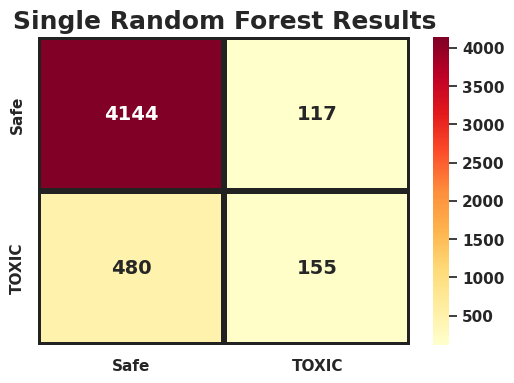


--- Single XGBoost ---
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88      4261
         1.0       0.39      0.79      0.52       635

    accuracy                           0.81      4896
   macro avg       0.68      0.80      0.70      4896
weighted avg       0.89      0.81      0.83      4896



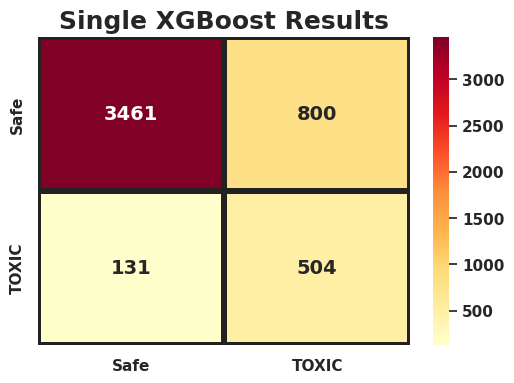

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Voting Ensemble ---
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89      4261
         1.0       0.41      0.78      0.54       635

    accuracy                           0.83      4896
   macro avg       0.69      0.81      0.72      4896
weighted avg       0.89      0.83      0.85      4896



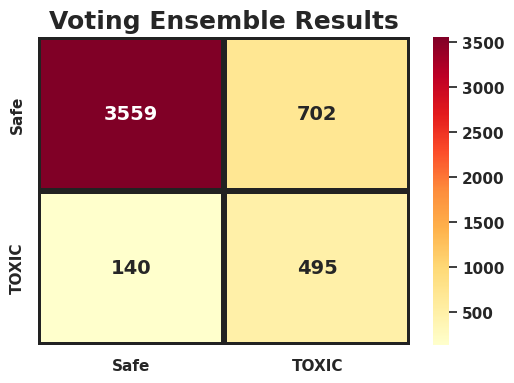


--- Stacking Ensemble ---
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93      4261
         1.0       0.67      0.12      0.21       635

    accuracy                           0.88      4896
   macro avg       0.78      0.56      0.57      4896
weighted avg       0.86      0.88      0.84      4896



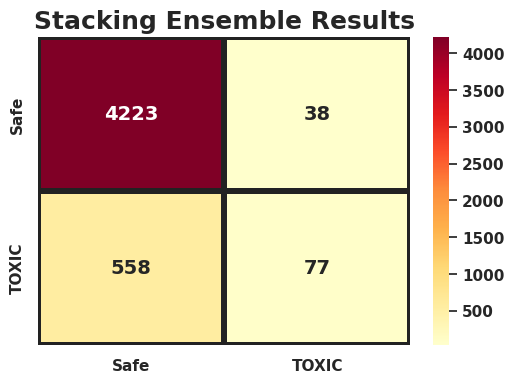

In [20]:
# --- 4. TRAINING & EVALUATION ---
models = {
    "Single Random Forest": RandomForestClassifier(**study_rf_final.best_params),
    "Single XGBoost": xgb.XGBClassifier(**study_xgb_final.best_params),
    "Voting Ensemble": VotingClassifier(estimators=[
        ('lr', LogisticRegression(class_weight='balanced')),
        ('rf', RandomForestClassifier(**study_rf_final.best_params)),
        ('xgb', xgb.XGBClassifier(**study_xgb_final.best_params))], voting='soft'),
    "Stacking Ensemble": StackingClassifier(estimators=[
        ('rf', RandomForestClassifier(**study_rf_final.best_params)),
        ('xgb', xgb.XGBClassifier(**study_xgb_final.best_params))],
        final_estimator=LogisticRegression(), cv=5)
}

results_probs = {}

def plot_mickey_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', linewidths=3, linecolor=MICKEY_BLACK,
                xticklabels=['Safe', 'TOXIC'], yticklabels=['Safe', 'TOXIC'], annot_kws={"size": 14, "weight": "bold"})
    plt.title(title)
    plt.show()

print("\n Evaluating All Models (Threshold 0.25)...")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    probs = model.predict_proba(X_test_scaled)[:, 1]
    results_probs[name] = probs
    
    preds_custom = (probs >= 0.25).astype(int)
    print(f"\n--- {name} ---")
    print(classification_report(y_test, preds_custom))
    plot_mickey_cm(y_test, preds_custom, f"{name} Results")

## <p style="background-color: #d4edda; font-family: Algerian; font-size: 200%; text-align: center; color: black; border-radius: 10px 10px;">Model Performance Comparison</p>

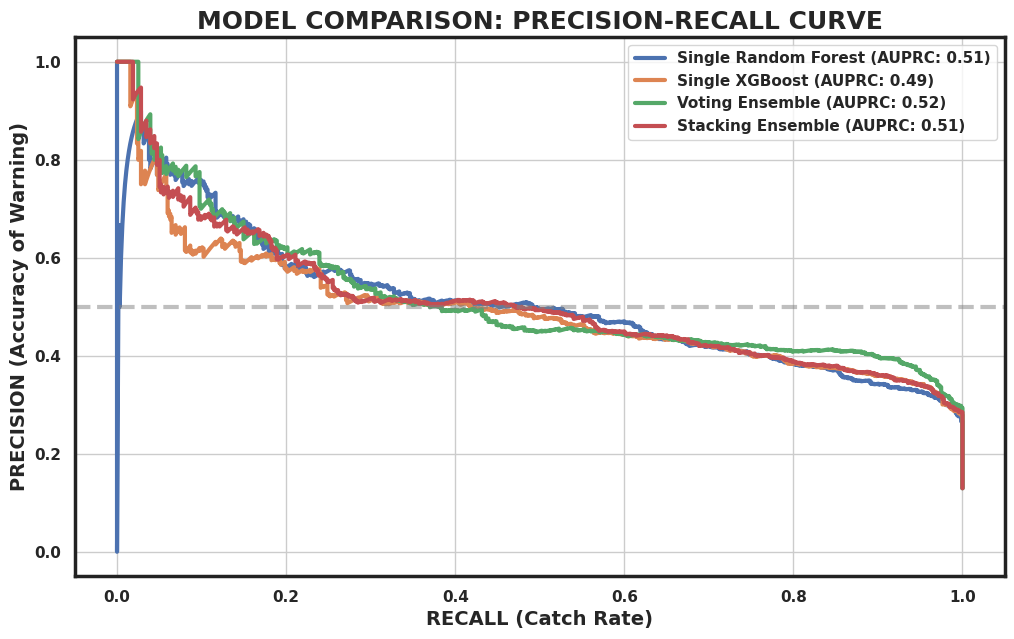

In [21]:
# --- 5. VISUAL COMPARISON (PR CURVES) ---
plt.figure(figsize=(12, 7))
for name, probs in results_probs.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    score = average_precision_score(y_test, probs)
    plt.plot(recall, precision, label=f'{name} (AUPRC: {score:.2f})')

plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
plt.title('MODEL COMPARISON: PRECISION-RECALL CURVE')
plt.xlabel('RECALL (Catch Rate)')
plt.ylabel('PRECISION (Accuracy of Warning)')
plt.legend()
plt.show()

/tmp/ipykernel_24/3040192560.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probs[y_test == 0], label=f"{name} (Safe)", shade=True, alpha=0.3)
/tmp/ipykernel_24/3040192560.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probs[y_test == 1], label=f"{name} (TOXIC)", shade=True, alpha=0.3)
/tmp/ipykernel_24/3040192560.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probs[y_test == 0], label=f"{name} (Safe)", shade=True, alpha=0.3)
/tmp/ipykernel_24/3040192560.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your

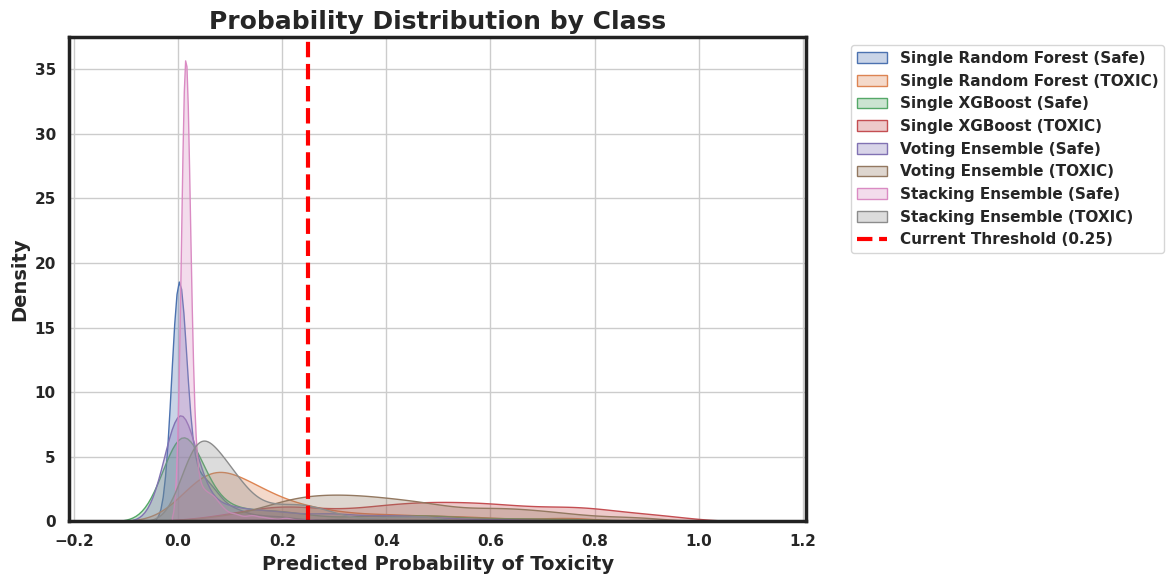

In [22]:
def plot_probability_distribution(results_probs, y_test):
    plt.figure(figsize=(12, 6))
    for name, probs in results_probs.items():
        sns.kdeplot(probs[y_test == 0], label=f"{name} (Safe)", shade=True, alpha=0.3)
        sns.kdeplot(probs[y_test == 1], label=f"{name} (TOXIC)", shade=True, alpha=0.3)
    
    plt.axvline(0.25, color='red', linestyle='--', label='Current Threshold (0.25)')
    plt.title("Probability Distribution by Class")
    plt.xlabel("Predicted Probability of Toxicity")
    plt.ylabel("Density")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_probability_distribution(results_probs, y_test)

In [23]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=feature_names,
    class_names=['Safe', 'Hazardous'],
    mode='classification'
)

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

idx = 10
exp = explainer.explain_instance(X_test_scaled_df.iloc[idx], models["Voting Ensemble"].predict_proba)
exp.show_in_notebook()
exp.save_to_file('lime_interpretation.html')

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

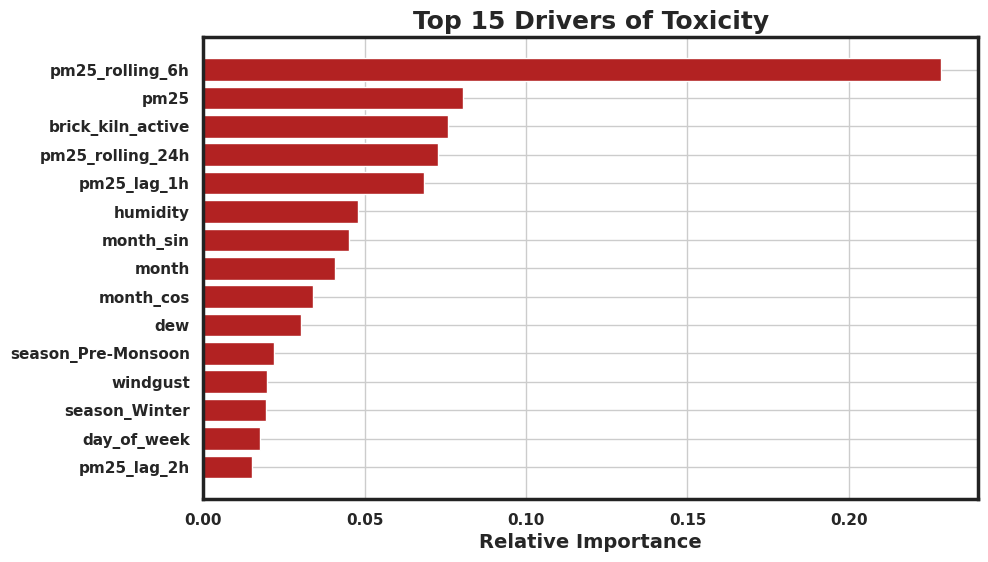

In [24]:
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-15:] 
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='firebrick', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_feature_importance(models["Single XGBoost"], X_train.columns, "Top 15 Drivers of Toxicity")

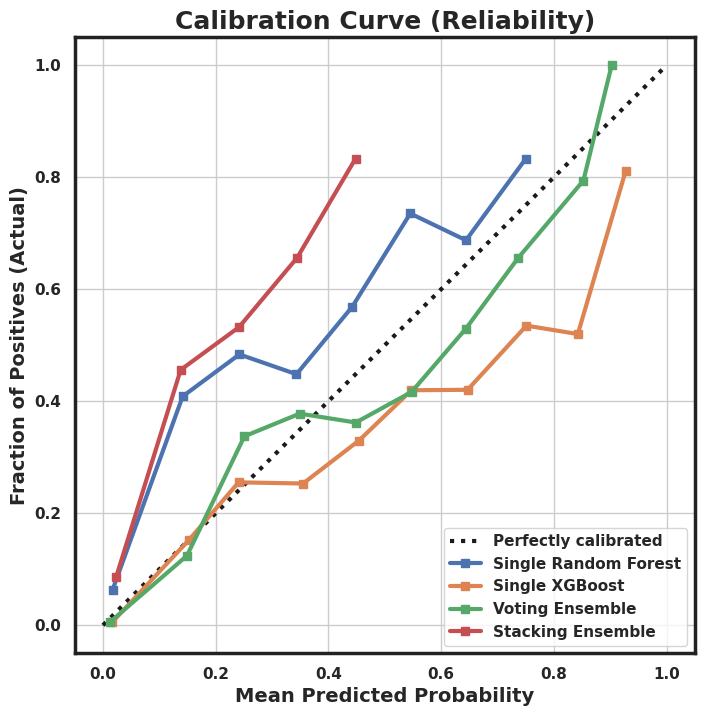

In [25]:
from sklearn.calibration import calibration_curve

def plot_calibration_curves(results_probs, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    for name, probs in results_probs.items():
        prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
        plt.plot(prob_pred, prob_true, "s-", label=name)

    plt.ylabel("Fraction of Positives (Actual)")
    plt.xlabel("Mean Predicted Probability")
    plt.title("Calibration Curve (Reliability)")
    plt.legend(loc="lower right")
    plt.show()

plot_calibration_curves(results_probs, y_test)

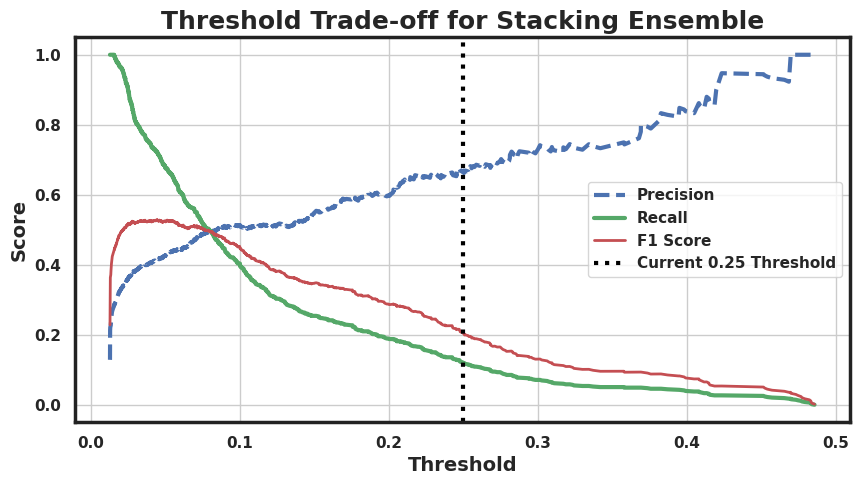

In [26]:
def plot_threshold_tradeoff(y_test, probs, model_name):
    precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.plot(thresholds, f1_scores[:-1], 'r-', label='F1 Score', linewidth=2)
    
    plt.axvline(0.25, color='black', linestyle=':', label='Current 0.25 Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Threshold Trade-off for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_threshold_tradeoff(y_test, results_probs["Stacking Ensemble"], "Stacking Ensemble")

## <p style="background-color: #d4edda; font-family: Algerian; font-size: 200%; text-align: center; color: black; border-radius: 10px 10px;"> Final Deployment Package</p>

In [ ]:
joblib.dump(models["Voting Ensemble"], '../models/voting_ensemble.pkl')
joblib.dump(models["Stacking Ensemble"], '../models/stacking_ensemble.pkl')
joblib.dump(models["Single Random Forest"], '../models/random_forest.pkl')
joblib.dump(models["Single XGBoost"], '../models/XGBoost.pkl')            
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(X.columns.tolist(), '../models/features.pkl')
print("\n Deployment Package Saved")


 Deployment Package Saved (Stacking Model).


## <p style="background-color: #d4edda; font-family: Algerian; font-size: 200%; text-align: center; color: black; border-radius: 10px 10px;">Performance Summary</p>

To conclude, the voting ensemble was superior to any other model when it comes to the Public
Health Early Warning System (PHEWS). It provides the best 24 hours early warning system
to Kathmandu because it provides a balanced mixture of high recall and better precision. This
guarantees that children and other vulnerable groups are well covered during hazardous events
to the tune of 85%, which is not only safe, but also reliable to the society.

| Model                | Catch Rate | Accuracy of Warning | Reliability | Status          |
|----------------------|------------|------------------|------------|----------------|
| Voting Ensemble      | ~85%        | ~41%              | ~0.56       | WINNER         |
| Single XGBoost       | ~94%        | ~34%              | ~0.50       | Over-reactive  |
| Single Random Forest | ~25%        | ~56%              | ~0.34       | Too Cautious   |
| Stacking Ensemble    | ~10%        | ~66%              | ~0.17       | Silent Fail    |
